<a href="https://colab.research.google.com/github/torrhen/pytorch/blob/main/04_pytorch_custom_datasets_ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [203]:
# Check for GPU
!nvidia-smi

Mon Dec 12 17:35:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    32W /  70W |   1934MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [204]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

1.13.0+cu116


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.



1.   More complex model (e.g. deeper network, removing dropout)
2.   Reducing the size of the training set
3.   Increasing the learning rate of gradient descent for faster convergence





## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [205]:
# 1. Get data

import requests # HTTP requests
from pathlib import Path # file management
import zipfile # file extracting

image_path = Path('data/pizza_steak_sushi')

# check if the file at the path is a directory
if image_path.is_dir():
  print(f"Image path already exists at {image_path}")
else:
  # create image directory
  image_path.mkdir(parents=True, exist_ok=True)
  # download images to directory from github by writing binary file
  with open(image_path / '.zip', 'wb') as f:
    response = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    f.write(response.content)

  # extract downloaded image folder
  with zipfile.ZipFile(image_path / '.zip', 'r') as z:
    z.extractall(image_path)

Image path already exists at data/pizza_steak_sushi


In [206]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 1 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.


In [207]:
# Setup train and testing paths
train_folder = image_path / 'train'
test_folder = image_path / 'test'

Label: steak


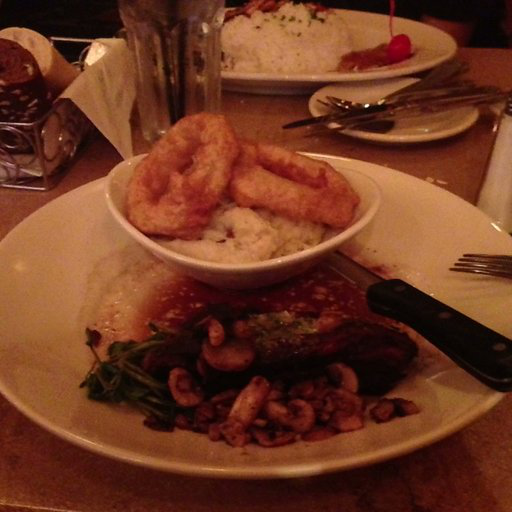

In [208]:
# Visualize an image
import random
from PIL import Image # python image library

random.seed(42)
# create a list of image file paths from the image folder
image_path_list = list(image_path.glob('*/*/*.jpg'))
# select a random image
rand_image_path = random.choice(image_path_list)
# select the class of the image from the image path structure
image_class = rand_image_path.parent.stem

# display image and label
img = Image.open(rand_image_path)
print(f"Label: {image_class}")
img

(-0.5, 511.5, 511.5, -0.5)

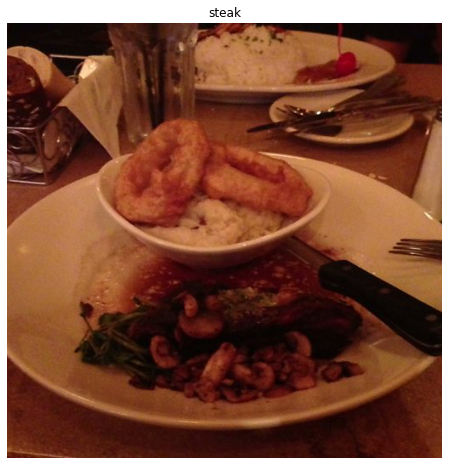

In [209]:
# Do the image visualization with matplotlib
import matplotlib.pyplot as plt
import numpy as np

mat_img = np.asarray(img)

plt.figure(figsize=(8,8))
plt.imshow(mat_img)
plt.title(image_class)
plt.axis(False)

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [210]:
# 3.1 Transforming data with torchvision.transforms
!pip install torchvision
from torchvision import transforms

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [211]:
# Write transform for turning images into tensors
transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor()
    ]
)

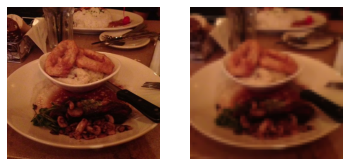

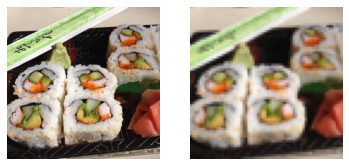

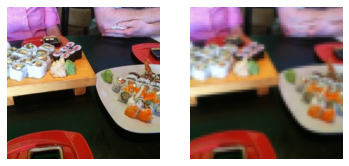

In [212]:
# Write a function to plot transformed images
def plot_image_transforms(images, transform, n_samples=3, random_seed=42):
  random.seed(random_seed)

  random_images = random.sample(images, k=n_samples)

  for img in random_images:
    with Image.open(img) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].axis(False)

      transformed_img = transform(f)
      transformed_img = transformed_img.permute(1, 2, 0)

      ax[1].imshow(transformed_img)
      ax[1].axis(False)

plot_image_transforms(image_path_list, transform)

### Load image data using `ImageFolder`

In [213]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_folder, transform=transform, target_transform=None)
test_data = datasets.ImageFolder(root=test_folder, transform=transform, target_transform=None)

In [214]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [215]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [216]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [217]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=32, shuffle=False)

In [218]:
# How many batches of images are in our data loaders?
print(f"Batches in train loader: {len(train_loader)}")
print(f"Batches in test loader: {len(test_loader)}")

Batches in train loader: 8
Batches in test loader: 3


## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [219]:
# TinyVGG model
from torch import nn

class TinyVGG(nn.Module):
  def __init__(self, input_size, hidden_units, output_size):
    super().__init__()
    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels=input_size, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16, out_features=output_size)
    )
  
  def forward(self, x):
    return self.fc(self.block2(self.block1(x)))


In [220]:
model = TinyVGG(3, 10, 3).to(device)

In [221]:
!pip install torchinfo

from torchinfo import summary

summary(model, input_size=[1, 3, 64, 64])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## 4. Create training and testing functions for `model_0`.

In [222]:
!pip install torchmetrics

from torchmetrics import Accuracy

accuracy_fn = Accuracy(task='multiclass', num_classes=len(train_data.classes)).to(device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [223]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    logits = model(X)
    
    # 2. Calculate and accumulate loss
    loss = loss_fn(logits, y)
    train_loss += loss

    # 3. Optimizer zero grad 
    optimizer.zero_grad()

    # 4. Loss backward 
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    labels = torch.argmax(torch.softmax(logits, dim=1), dim=1)
    acc = accuracy_fn(labels, y)
    train_acc += acc

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

In [224]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  
  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      logits = model(X)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(logits, y)
      test_loss += loss

      # Calculate and accumulate accuracy
      labels = torch.argmax(torch.softmax(logits, dim=1), dim=1)
      acc = accuracy_fn(labels, y)
      test_acc += acc
    
    # Adjust metrics to get average loss and accuracy per batch
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss, test_acc

In [225]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model, 
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model, 
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    
    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 

In [226]:
# instantiate model
model1 = TinyVGG(3, 10, 3).to(device)

In [227]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model1.parameters(), 
                             lr=0.001)

In [228]:
model1_results = train(model1, train_loader, test_loader, optimizer, loss_fn, epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1079 | train_acc: 0.2500 | test_loss: 1.1069 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0817 | train_acc: 0.4258 | test_loss: 1.1320 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0800 | train_acc: 0.4258 | test_loss: 1.1621 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1263 | train_acc: 0.3047 | test_loss: 1.1622 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0886 | train_acc: 0.4258 | test_loss: 1.1490 | test_acc: 0.2604


In [229]:
model2 = TinyVGG(3, 10, 3).to(device)

In [230]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model2.parameters(), 
                             lr=0.001)

In [231]:
model2_results = train(model2, train_loader, test_loader, optimizer, loss_fn, epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1043 | train_acc: 0.2812 | test_loss: 1.1071 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0725 | train_acc: 0.4258 | test_loss: 1.1419 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0672 | train_acc: 0.4258 | test_loss: 1.1583 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.0439 | train_acc: 0.4570 | test_loss: 1.0812 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.0209 | train_acc: 0.4531 | test_loss: 1.0540 | test_acc: 0.3229
Epoch: 6 | train_loss: 0.9775 | train_acc: 0.4297 | test_loss: 1.0330 | test_acc: 0.3428
Epoch: 7 | train_loss: 0.8927 | train_acc: 0.5469 | test_loss: 1.0488 | test_acc: 0.4725
Epoch: 8 | train_loss: 0.8708 | train_acc: 0.6055 | test_loss: 1.1490 | test_acc: 0.3021
Epoch: 9 | train_loss: 0.9669 | train_acc: 0.4531 | test_loss: 0.9824 | test_acc: 0.4830
Epoch: 10 | train_loss: 0.9529 | train_acc: 0.4375 | test_loss: 0.9525 | test_acc: 0.5843
Epoch: 11 | train_loss: 0.8361 | train_acc: 0.6250 | test_loss: 1.0879 | test_acc: 0.3229
Epoch: 12 | train_l

In [232]:
model3 = TinyVGG(3, 10, 3).to(device)

In [233]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model3.parameters(), 
                             lr=0.001)

In [234]:
model3_results = train(model3, train_loader, test_loader, optimizer, loss_fn, 50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1035 | train_acc: 0.2500 | test_loss: 1.0955 | test_acc: 0.4848
Epoch: 2 | train_loss: 1.0876 | train_acc: 0.4414 | test_loss: 1.1052 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0700 | train_acc: 0.4258 | test_loss: 1.1336 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1160 | train_acc: 0.3047 | test_loss: 1.1407 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0598 | train_acc: 0.4258 | test_loss: 1.1183 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1162 | train_acc: 0.3047 | test_loss: 1.1255 | test_acc: 0.2708
Epoch: 7 | train_loss: 1.0564 | train_acc: 0.5352 | test_loss: 1.1146 | test_acc: 0.2396
Epoch: 8 | train_loss: 1.0761 | train_acc: 0.3906 | test_loss: 1.1390 | test_acc: 0.2500
Epoch: 9 | train_loss: 1.1060 | train_acc: 0.3828 | test_loss: 1.1364 | test_acc: 0.2708
Epoch: 10 | train_loss: 1.0234 | train_acc: 0.4102 | test_loss: 1.0568 | test_acc: 0.3788
Epoch: 11 | train_loss: 1.0248 | train_acc: 0.4414 | test_loss: 1.0725 | test_acc: 0.3409
Epoch: 12 | train_l

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [235]:
model4 = TinyVGG(3, 20, 3).to(device)

In [236]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model4.parameters(), 
                             lr=0.001)

model4_results = train(model4, train_loader, test_loader, optimizer, loss_fn, 50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1039 | train_acc: 0.4766 | test_loss: 1.1155 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0720 | train_acc: 0.4258 | test_loss: 1.1456 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0750 | train_acc: 0.4258 | test_loss: 1.1638 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1126 | train_acc: 0.3047 | test_loss: 1.1268 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0658 | train_acc: 0.4766 | test_loss: 1.1140 | test_acc: 0.2812
Epoch: 6 | train_loss: 1.1215 | train_acc: 0.3672 | test_loss: 1.1337 | test_acc: 0.2812
Epoch: 7 | train_loss: 1.0098 | train_acc: 0.5039 | test_loss: 1.1047 | test_acc: 0.2604
Epoch: 8 | train_loss: 0.9911 | train_acc: 0.5938 | test_loss: 1.0581 | test_acc: 0.3731
Epoch: 9 | train_loss: 0.9464 | train_acc: 0.5000 | test_loss: 1.1665 | test_acc: 0.4839
Epoch: 10 | train_loss: 0.8843 | train_acc: 0.6211 | test_loss: 0.9717 | test_acc: 0.3920
Epoch: 11 | train_loss: 0.8268 | train_acc: 0.6523 | test_loss: 1.1022 | test_acc: 0.3835
Epoch: 12 | train_l

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [237]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...") 
    zip_ref.extractall(image_path)

data/pizza_steak_sushi_20_percent directory exists.
Unzipping pizza, steak, sushi 20% data...


In [238]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.


Excellent, we now have double the training and testing images... 

In [239]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [240]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

augment_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.TrivialAugmentWide(num_magnitude_bins=31),                                     
  transforms.ToTensor()
])

# Create datasets
train_data_20_percent_dataset = ImageFolder(root=train_data_20_percent_path, transform=augment_transform, target_transform=None)
test_data_20_percent_dataset = ImageFolder(root=test_data_20_percent_path, transform=augment_transform, target_transform=None)

# Create dataloaders
train_loader_20_percent = DataLoader(dataset=train_data_20_percent_dataset, batch_size=32, shuffle=True)
test_loader_20_percent = DataLoader(dataset=test_data_20_percent_dataset, batch_size=32, shuffle=False)

In [241]:
model5 = TinyVGG(3, 20, 3).to(device)

In [242]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model5.parameters(), lr=0.001)

model5_results = train(model5, train_loader_20_percent, test_loader_20_percent, optimizer, loss_fn, 20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1035 | train_acc: 0.3271 | test_loss: 1.0982 | test_acc: 0.2875
Epoch: 2 | train_loss: 1.1047 | train_acc: 0.3250 | test_loss: 1.0903 | test_acc: 0.3000
Epoch: 3 | train_loss: 1.0897 | train_acc: 0.4396 | test_loss: 1.0541 | test_acc: 0.5051
Epoch: 4 | train_loss: 1.0444 | train_acc: 0.5021 | test_loss: 0.9992 | test_acc: 0.5250
Epoch: 5 | train_loss: 0.9997 | train_acc: 0.5229 | test_loss: 1.0576 | test_acc: 0.3801
Epoch: 6 | train_loss: 0.9770 | train_acc: 0.4813 | test_loss: 1.0070 | test_acc: 0.4733
Epoch: 7 | train_loss: 1.0082 | train_acc: 0.4833 | test_loss: 0.9838 | test_acc: 0.5148
Epoch: 8 | train_loss: 0.9657 | train_acc: 0.5250 | test_loss: 0.9931 | test_acc: 0.4705
Epoch: 9 | train_loss: 0.9248 | train_acc: 0.5583 | test_loss: 0.9743 | test_acc: 0.5085
Epoch: 10 | train_loss: 1.0046 | train_acc: 0.4813 | test_loss: 1.0148 | test_acc: 0.4892
Epoch: 11 | train_loss: 0.9059 | train_acc: 0.5938 | test_loss: 0.8975 | test_acc: 0.5460
Epoch: 12 | train_l

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction. 
* Does the model you trained in exercise 7 get it right? 
* If not, what do you think you could do to improve it?

In [243]:
import torchvision
# read in custom image as tensor
image_path = 'steak.jpeg'
img = torchvision.io.read_image(image_path)
img

tensor([[[ 58,  60,  60,  ..., 197, 203, 200],
         [ 57,  59,  60,  ..., 196, 203, 210],
         [ 56,  58,  60,  ..., 203, 208, 216],
         ...,
         [235, 238, 234,  ..., 162, 148, 142],
         [223, 232, 240,  ..., 149, 147, 171],
         [240, 248, 238,  ..., 167, 182, 204]],

        [[ 70,  72,  73,  ..., 190, 201, 200],
         [ 69,  71,  73,  ..., 190, 201, 209],
         [ 68,  70,  72,  ..., 194, 202, 210],
         ...,
         [229, 232, 230,  ..., 142, 130, 133],
         [214, 226, 234,  ..., 134, 134, 164],
         [230, 240, 229,  ..., 159, 176, 199]],

        [[ 32,  32,  30,  ..., 197, 204, 200],
         [ 31,  31,  30,  ..., 194, 204, 207],
         [ 32,  32,  32,  ..., 197, 204, 210],
         ...,
         [229, 232, 229,  ..., 131, 120, 118],
         [215, 226, 234,  ..., 127, 126, 154],
         [229, 238, 230,  ..., 146, 164, 193]]], dtype=torch.uint8)

In [244]:
model5.eval()
with torch.inference_mode():
  # normalize
  img = img / 255
  # resize the image to 64x64
  resize_transform = transforms.Resize((64, 64))
  img = resize_transform(img)
  # add a single batch dimension and allocate to device
  img = img.unsqueeze(dim=0).to(device)

  # predict the class of the custom image
  pred_logit = model5(img)
  pred_label = torch.argmax(torch.softmax(pred_logit, dim=1), dim=1)
  pred_class = test_data_20_percent_dataset.classes[pred_label]

print(pred_class)

sushi
